# Question 2

#### Imports

In [208]:
import itertools
import os
from datetime import datetime

import numpy as np

from classify import temperature
from classify.data.responses import responses_to_traffic_array
from classify.data.traffic import load_traffic
from classify.scenario.bridge import healthy_damage, pier_disp_damage
from classify.scenario.traffic import normal_traffic
from fem.responses import load_fem_responses
from fem.run.opensees import OSRunner
from model.bridge import Point
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config
from model.response import ResponseType
from plot import plt
from util import resize_units

#### Config

In [253]:
DATA_PATH = "/Users/jeremy/Desktop/mesh-med-600-mar/"
IMAGE_PATH = "/Users/jeremy/Desktop/saved-images/"
ERROR_TERM = True
c = bridge_705_med_config(bridge_705_3d)
# Set the directory of where to save/load responses.
c.root_generated_data_dir = os.path.join(DATA_PATH, c.root_generated_data_dir)

INFO: Loaded vehicle data from /Users/jeremy/cs/bridge-dss/data/a16-data/a16.csv in 0.11s
WARN: Vehicle PDF sums to 99.5, adjusted to sum to 1


#### Aliases and sensors

In [254]:
# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

sensor_point = Point(x=21, y=0, z=-8.4)  # A sensor point to investigate.
# sensor_point = Point(x=33, y=0, z=-4)  # A sensor point to investigate.

#### Traffic data

In [255]:
total_mins = 24
total_seconds = total_mins * 60
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence_0, traffic_0, traffic_array_0 = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)

/Users/jeremy/Desktop/mesh-med-600-mar/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-1440-0,01.npy


#### 2019 temperature data

In [256]:
# Load minute-by-minute temperature data for the year.
from_ = datetime.fromisoformat(f"2019-01-01T00:00")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_2019 = temperature.from_to_mins(temperature.load("holly-springs"), from_, to)
temps_2019["temp"] = temperature.resize(temps_2019["temp"])

Temperature (0.001, 0.999) quantiles = -9.5, 34.5


In [257]:
# Effect of annual temperature.
effect_2019_y = resize_y(temperature.effect(c=c, response_type=rt_y, points=[sensor_point], temps=temps_2019["temp"], solar=temps_2019["solar"], len_per_hour=60)[0])
effect_2019_s = temperature.effect(c=c, response_type=rt_s, points=[sensor_point], temps=temps_2019["temp"], solar=temps_2019["solar"], len_per_hour=60)[0]
assert len(temps_2019) == len(effect_2019_y)

#### Response to 2mm pier settlement

In [258]:
error_scenario = pier_disp_damage([(5, 2 / 1000)])
error_response = float(load_fem_responses(
    c=error_scenario.use(c)[0],
    sim_params=error_scenario.use(c)[1],
    response_type=ResponseType.YTranslation,
    sim_runner=OSRunner,
).at_deck(point=sensor_point, interp=True))
error_response

-0.0007510319901427902

#### 2018 temperature data

In [259]:
# Load minute-by-minute temperature data for the year.
from_ = datetime.fromisoformat(f"2018-01-01T00:00")
to = datetime.fromisoformat(f"2018-12-31T23:59")
temps_2018 = temperature.from_to_mins(temperature.load("holly-springs-18"), from_, to)
temps_2018["temp"] = temperature.resize(temps_2018["temp"])

Temperature (0.001, 0.999) quantiles = -16.6881, 33.5


In [260]:
# Effect of annual temperature.
effect_2018_y = resize_y(temperature.effect(c=c, response_type=rt_y, points=[sensor_point], temps=temps_2018["temp"], solar=temps_2018["solar"], len_per_hour=60)[0])
print(np.min(effect_2018_y), effect_2018_y.shape)
effect_2018_s = temperature.effect(c=c, response_type=rt_s, points=[sensor_point], temps=temps_2018["temp"], solar=temps_2018["solar"], len_per_hour=60)[0]
assert len(temps_2018) == len(effect_2018_y)
if ERROR_TERM:
    error_y = resize_y(error_response)
    effect_2018_y = effect_2018_y + np.interp(np.arange(len(effect_2018_y)), [0, len(effect_2018_y) - 1], [0, error_y])
    print(np.min(effect_2018_y), effect_2018_y.shape)

-0.4084914088606301MResponses in 0.01s, (ResponseType.YTranslation) (525600,)
-0.973472773039743EMResponses in 0.04s, (ResponseType.Strain) (525600,)


#### Regression of 2018 temperature data

In [261]:
daily_samples = 60 * 24
num_days_2018 = len(temps_2018) / daily_samples
assert num_days_2018 == 365

regress_temps_2018 = []
regress_y_2018 = []
regress_s_2018 = []
regress_dates_2018 = []
for i in range(int(num_days_2018)):
    lo = i * daily_samples
    hi = lo + daily_samples
    regress_temps_2018.append(np.median(temps_2018["temp"][lo:hi]))
    regress_y_2018.append(np.median(effect_2018_y[lo:hi]))
    regress_s_2018.append(np.median(effect_2018_s[lo:hi]))
    regress_dates_2018.append(temps_2018["datetime"][int((lo + hi) / 2)])
regress_temps_2018 = np.array(regress_temps_2018)
regress_y_2018 = np.array(regress_y_2018)
regress_s_2018 = np.array(regress_s_2018)
regress_dates_2018 = np.array(regress_dates_2018)
# Linear regression of Y translation.
lr_y_2018, errors_lr_y = temperature.regress_and_errors(regress_temps_2018, regress_y_2018)
print(f"Max = {np.max(errors_lr_y)}, mean = {np.mean(errors_lr_y)}, std = {np.std(errors_lr_y)}")
# Linear regression of strain.
lr_s_2018, errors_lr_s = temperature.regress_and_errors(regress_temps_2018, regress_s_2018)
print(f"Max = {np.max(errors_lr_s)}, mean = {np.mean(errors_lr_s)}, std = {np.std(errors_lr_s)}")

Max = 0.6414435428324708, mean = 0.17303852700176509, std = 0.14662830969808807
Max = 5.978526954093957e-05, mean = 1.1724493144795998e-05, std = 1.0072091029679475e-05


#### Setup each damage scenario.

In [262]:
damage_scenarios = [healthy_damage, pier_disp_damage([(5, 3 / 1000)])]
traffic_arrays = [traffic_array_0, traffic_array_0]
damage_names = ["Healthy", "Pier settlement by 3 mm"]
response_types = [rt_y, rt_s]

#### Collect responses under each damage scenario.

In [263]:
responses = [[None for _ in response_types] for _ in damage_scenarios]
for d_i, (damage_scenario, traffic_array) in enumerate(zip(damage_scenarios, traffic_arrays)):
    for r_i, response_type in enumerate(response_types):
        responses[d_i][r_i] = responses_to_traffic_array(
            c=damage_scenario.use(c)[0],
            traffic_array=traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor_point],
        ).T[0]  # Responses from a single point.
        # Resize responses into mm and strain.
        if response_type == rt_y:
            responses[d_i][r_i] = resize_y(responses[d_i][r_i])
        elif response_type == rt_s:
            responses[d_i][r_i] = resize_s(responses[d_i][r_i])
responses = np.array(responses)
responses.shape

(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)uilt FEMResponses in 0.01s, (ResponseType.YTranslation)
(2400, 1)


(2, 2, 144001)

#### Removal of temperature effect

In [264]:
downsample = 100
data = []
datetimes = []
for month_i, day_i in itertools.product([7, 8, 9, 10, 11, 12], np.arange(1, 30 + 1)):
    day_str, month_str = str(day_i), str(month_i)
    if len(day_str) == 1: day_str = "0" + day_str
    if len(month_str) == 1: month_str = "0" + month_str
    # Get temperatures for 2019.
    temp_i, temp_j = temperature.ij(temps_2019, f"2019-{month_str}-{day_str}T00:00", f"2019-{month_str}-{day_str}T23:59")
    day_temp = np.mean(temps_2019["temp"][temp_i:temp_j])
    print(f"Day, month = {day_str}, {month_str}, Mean day temperature = {day_temp:.3f}", end="\r")
    # Remove annual temperature component based on 2018.
    rm_year_s = lr_s_2018.predict([[day_temp]])[0]
    rm_year_y = lr_y_2018.predict([[day_temp]])[0]
    datetimes.append(datetime.fromisoformat(f"2019-{month_str}-{day_str}T00:00"))
    data.append([])
    for (traffic_y, traffic_s), damage_name in zip(responses, damage_names):
        temp_y = temperature.apply(effect=effect_2019_y[temp_i:temp_j], responses=traffic_y)
        temp_s = temperature.apply(effect=effect_2019_s[temp_i:temp_j], responses=traffic_y)
        _rm_24h_y, rm_24h_y = temperature.remove_sampled(24, traffic_y + temp_y)
        _rm_24h_s, rm_24h_s = temperature.remove_sampled(24, traffic_s + temp_s)
        signal_s = traffic_s + temp_s - rm_24h_s - rm_year_s
        signal_y = traffic_y + temp_y - rm_24h_y - rm_year_y
#         signal_s = traffic_s + temp_s - rm_year_s
#         signal_y = traffic_y + temp_y - rm_year_y
        data[-1].append(np.array([signal_y, signal_s]))
data = np.array(data)
# data = np.resize(data, (data.shape[1], data.shape[2], data.shape[0], data.shape[3]))
data.shape

(180, 2, 2, 144001)

#### 6 month daily prediction

In [265]:
healthy_daily, pier_daily = [], []
for day_i in range(data.shape[0]):
    healthy_daily.append(np.mean(data[day_i][0][0]))
    pier_daily.append(np.mean(data[day_i][1][0]))
healthy_daily, pier_daily = np.array(healthy_daily), np.array(pier_daily)

#### 6 month 14 day prediction

In [266]:
days = 14  # Number of days for robust estimator.
healthy_robust, pier_robust = [], []
for i in range(days, len(healthy_daily)):
    healthy_robust.append(np.mean(healthy_daily[i-days:i]))
    pier_robust.append(np.mean(pier_daily[i-days:i]))
healthy_robust, pier_robust = np.array(healthy_robust), np.array(pier_robust)

#### Plotting prediction

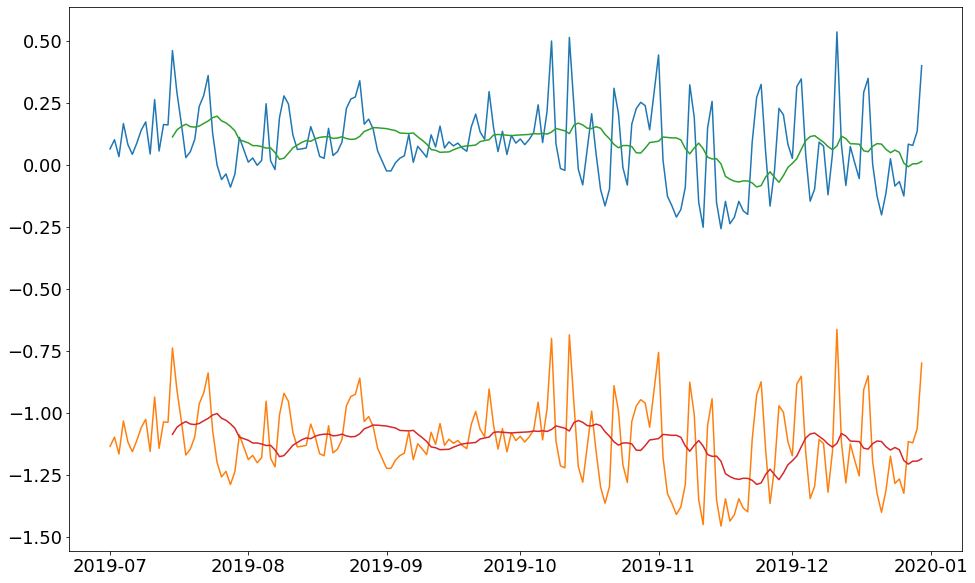

In [267]:
plt.plot(datetimes, healthy_daily)
plt.plot(datetimes, pier_daily)
plt.plot(datetimes[days:], healthy_robust)
plt.plot(datetimes[days:], pier_robust)

#### Classify based on accuracy

In [268]:
thresholds = np.arange(start=1, stop=-3, step=-0.01)
count_hs_robust, count_ps_robust = [], []
for threshold in thresholds:
    count_h, count_p = 0, 0
    for day_i in range(len(healthy_robust)):
        if healthy_robust[day_i] < threshold:
            count_h += 1
        if pier_robust[day_i] < threshold:
            count_p += 1
    count_hs_robust.append(count_h)
    count_ps_robust.append(count_p)
count_hs_robust, count_ps_robust = np.array(count_hs_robust), np.array(count_ps_robust)
#     print(f"Threshold = {threshold}, healthy: {count_h / len(healthy_robust)}, pier: {count_p / len(healthy_robust)}")

In [269]:
thresholds = np.arange(start=1, stop=-3, step=-0.01)
count_hs_daily, count_ps_daily = [], []
for threshold in thresholds:
    count_h, count_p = 0, 0
    for day_i in range(len(healthy_daily)):
        if healthy_daily[day_i] < threshold:
            count_h += 1
        if pier_daily[day_i] < threshold:
            count_p += 1
    count_hs_daily.append(count_h)
    count_ps_daily.append(count_p)
count_hs_daily, count_ps_daily = np.array(count_hs_daily), np.array(count_ps_daily)
#     print(f"Threshold = {threshold}, healthy: {count_h / len(healthy_robust)}, pier: {count_p / len(healthy_robust)}")

#### Truth

In [270]:
truth_response = float(load_fem_responses(
    c=damage_scenarios[-1].use(c)[0],
    sim_params=damage_scenarios[-1].use(c)[1],
    response_type=ResponseType.YTranslation,
    sim_runner=OSRunner,
).at_deck(point=sensor_point, interp=True)) * 1000
truth_response

-1.126546320255305

#### Plot threshold.

INFO: Saving image to /Users/jeremy/Desktop/saved-images/fp-fp-tn-tp-21--8.pdf


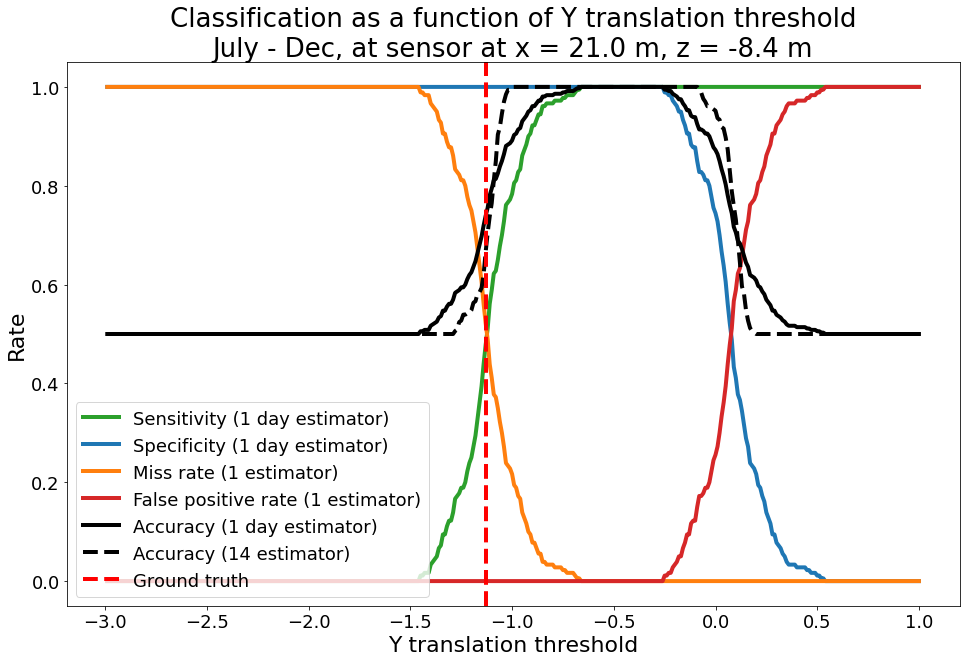

In [272]:
plt.landscape()
tp1, fn1 = count_ps_daily, len(pier_daily) - count_ps_daily
tn1, fp1 = len(pier_daily) - count_hs_daily, count_hs_daily
tp, fn = count_ps_robust, len(pier_robust) - count_ps_robust
tn, fp = len(pier_robust) - count_hs_robust, count_hs_robust
# plt.plot(thresholds, tp / len(pier_robust), label="True negative", color="tab:blue", lw=4)
# plt.plot(thresholds, fn / len(pier_robust), label="False positive", color="tab:red", lw=4)
# plt.plot(thresholds, tn / len(pier_robust), label="True positive", color="tab:green", lw=4)
# plt.plot(thresholds, fp / len(pier_robust), label="False negative", color="tab:orange", lw=4)
plt.plot(thresholds, (tp1) / (fn1 + tp1), label="Sensitivity (1 day estimator)", color="tab:green", lw=4)
plt.plot(thresholds, (tn1) / (fp1 + tn1), label="Specificity (1 day estimator)", color="tab:blue", lw=4)
plt.plot(thresholds, (fn1) / (fn1 + tp1), label="Miss rate (1 estimator)", color="tab:orange", lw=4)
plt.plot(thresholds, (fp1) / (fp1 + tn1), label="False positive rate (1 estimator)", color="tab:red", lw=4)
plt.plot(thresholds, (tn1 + tp1) / (fn1 + fp1 + tn1 + tp1), label="Accuracy (1 day estimator)", color="black", lw=4)
plt.plot(thresholds, (tn + tp) / (fn + fp + tn + tp), label="Accuracy (14 estimator)", color="black", linestyle="dashed", lw=4)
plt.axvline(truth_response, label="Ground truth", color="red", linestyle="dashed", lw=4)
plt.ylabel("Rate")
plt.xlabel("Y translation threshold")
plt.legend(loc="lower left")
plt.title(f"Classification as a function of Y translation threshold\nJuly - Dec, at sensor at x = {sensor_point.x:.1f} m, z = {sensor_point.z:.1f} m")
plt.savefig(os.path.join(IMAGE_PATH, f"fp-fp-tn-tp-{sensor_point.x:.0f}-{sensor_point.z:.0f}.pdf"))